# Работа с лицами на изображениях и видео

Выполним импорт необходимых библиотек

In [1]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np 
import os
import matplotlib.pyplot as plt

%matplotlib inline

Следующий код взят отсюда: https://colab.research.google.com/notebooks/snippets/advanced_outputs.ipynb#scrollTo=Camera_Capture - здесь вообще есть несколько интересных примеров взаимодействия Python и JavaScript в Colab. Чтобы получить доступ к веб-камере из Google Colab, выполним:

In [2]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


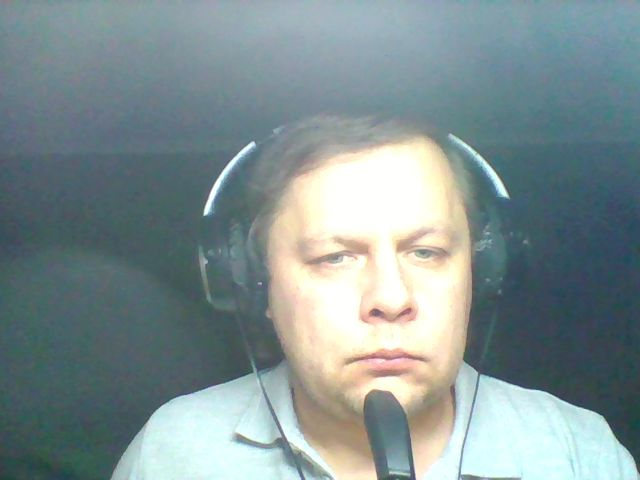

In [4]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))


Теперь полученный файл **photo.jpg** используем для знакомства с возможностями детекции лиц из разных библиотек

In [5]:
!ls

photo.jpg  sample_data


## Некоторые библиотеки детекции лиц 


### Детекция лиц в Open CV

Начнем с известной нам библиотеки Open CV и применения алгоритма каскада Хаара (его идея была предложена в статье за Пола Виолы (Paul Viola) и Майкла Джонса (Michael Jones)). Обученный каскад Хаара, принимая на вход изображение, определяет, есть ли на нем искомый объект, т.е. выполняет задачу классификации, разделяя входные данные на два класса (есть искомый объект / нет искомого объекта), и даже позволяет отыскивать глаза на лице (см., например, [тут](https://pythonprogramming.net/haar-cascade-face-eye-detection-python-opencv-tutorial/)).

Сначала загрузим при помощи **wget** необходимые для детекции файлы

In [6]:
!wget -o haarcascade_frontalface_default.xml https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
!wget -o haarcascade_profileface.xml https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_profileface.xml

--2021-11-28 17:29:22--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘haarcascade_frontalface_default.xml’

haarcascade_frontal 100%[===================>] 908.33K  --.-KB/s    in 0.05s   

2021-11-28 17:29:22 (19.6 MB/s) - ‘haarcascade_frontalface_default.xml’ saved [930127/930127]

--2021-11-28 17:29:22--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_profileface.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:

In [7]:
!ls

haarcascade_frontalface_default.xml  photo.jpg
haarcascade_profileface.xml	     sample_data


и определим соответствующие объекты


In [8]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
face_profile_cascade = cv2.CascadeClassifier('haarcascade_profileface.xml')

Подгрузим рабочие файлы

In [9]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('Файл(ы) "{name}" размером {length} байт загружен(ы)'.format(
      name=fn, length=len(uploaded[fn])))

Saving IMG_TKPM-scaled.jpg to IMG_TKPM-scaled.jpg
Saving Kleo.jpg to Kleo.jpg
Saving Kleo.mp4 to Kleo.mp4
Saving people.jpg to people.jpg
Saving Photo.jpg to Photo.jpg
Saving video1.mp4 to video1.mp4
Файл(ы) "IMG_TKPM-scaled.jpg" размером 521472 байт загружен(ы)
Файл(ы) "Kleo.jpg" размером 33358 байт загружен(ы)
Файл(ы) "Kleo.mp4" размером 709350 байт загружен(ы)
Файл(ы) "people.jpg" размером 380078 байт загружен(ы)
Файл(ы) "Photo.jpg" размером 271749 байт загружен(ы)
Файл(ы) "video1.mp4" размером 1061785 байт загружен(ы)


Получим список доступных картинок с расширением **jpg** 

In [10]:
photos = list(filter(lambda x : '.jpg' in x, os.listdir()))
photos

['IMG_TKPM-scaled.jpg', 'photo.jpg', 'Photo.jpg', 'Kleo.jpg', 'people.jpg']

Определим функцию детекции лиц на основе Open CV

In [31]:
def face_det_cv2(photo_name):
    img = cv2.imread(photo_name)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Для детекции нужно сделать изображение черно-белым
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Детектируем лица в анфас
    faces = face_cascade.detectMultiScale(gray, 1.1, 5, minSize=(200, 200)) # 1.1 и 5 - это гиперпараметры, их перебор позволяет регулировать детекцию
    # Нарисуем зеленые прямоугольники вокруг лиц.
    for (x, y, w, h) in faces:
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 5)

    # проверим лица в профиль
    faces = face_profile_cascade.detectMultiScale(gray, 1.1, 3, minSize=(200, 200))
    # Нарисуем прямоугольники вокруг лиц.
    for (x, y, w, h) in faces:
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 5)
    # Посмотрим что получилось
    plt.figure(figsize=(8,8), dpi=90)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()


Запустим детекцию лиц на фото

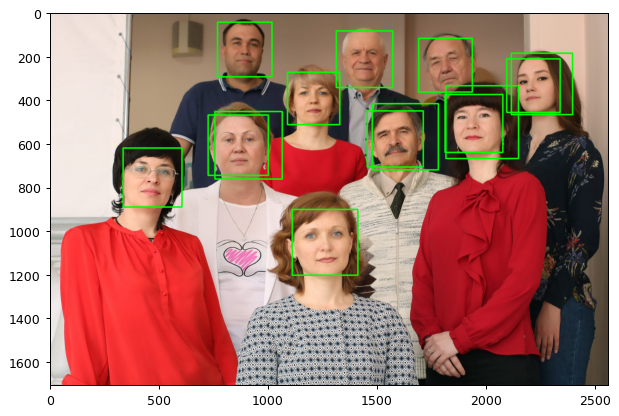

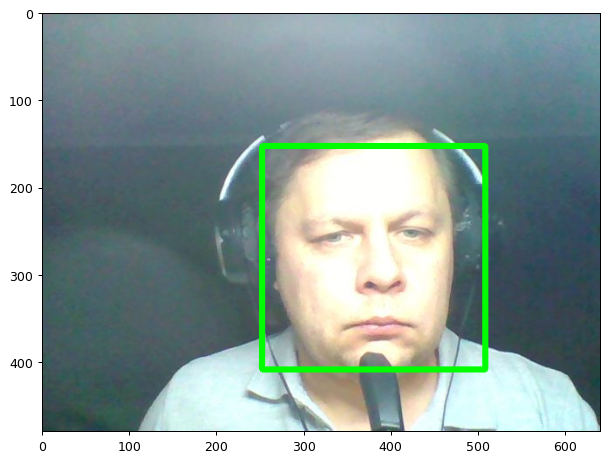

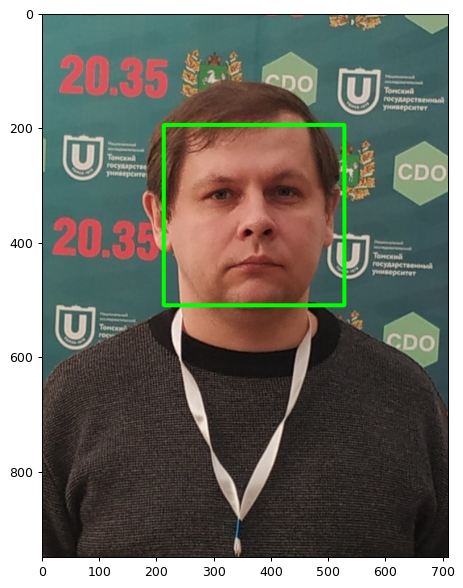

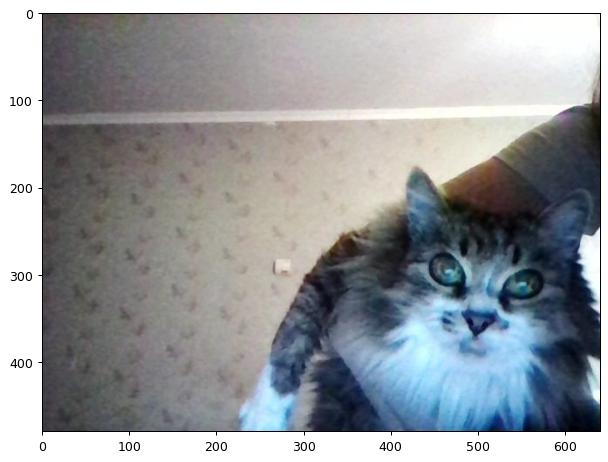

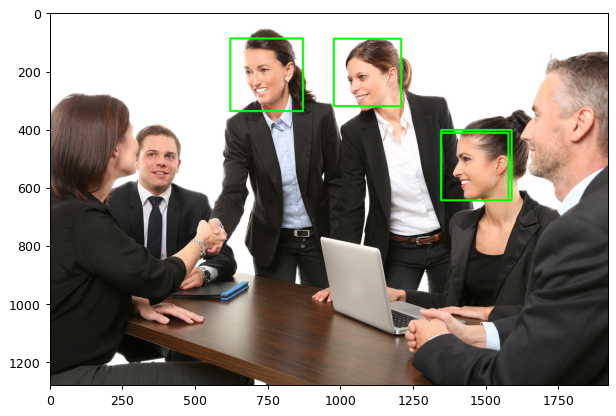

In [32]:
for photo in photos:
    face_det_cv2(photo)

### Детекция лиц в Face recognition

Библиотека face_recognition реализует огромные возможности dlib, может использоваться в различных обработках видео, при этом не сильно загружая ПК (см., например, [тут](https://vc.ru/dev/252648-kak-iskat-nuzhnyh-lyudey-na-kartinke-sam-sebe-poiskovik)).


In [13]:
!pip install face_recognition

     |████████████████████████████████| 100.1 MB 23 kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566185 sha256=027b3d8caea44814b628b855b573a8a0909f452ce96be3adf45b198326b38e27
  Stored in directory: /root/.cache/pip/wheels/d6/81/3c/884bcd5e1c120ff548d57c2ecc9ebf3281c9a6f7c0e7e7947a
Successfully built face-recognition-models


Импортируем библиотеку

In [14]:
import face_recognition

Определим функцию детекции лиц на основе Face recognition

In [15]:
def face_det_fr(photo_name):
    image_processed = face_recognition.load_image_file(photo_name)
    face_location = face_recognition.face_locations(image_processed)
    img = cv2.imread(photo_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for (top, right, bottom, left) in (face_location):
        cv2.rectangle(img, (left, top), (right, bottom), (0, 255, 0), 5)
    # Посмотрим что получилось
    plt.figure(figsize=(8,8), dpi=90)
    plt.imshow(img)
    plt.show()

Запустим детекцию лиц на фото

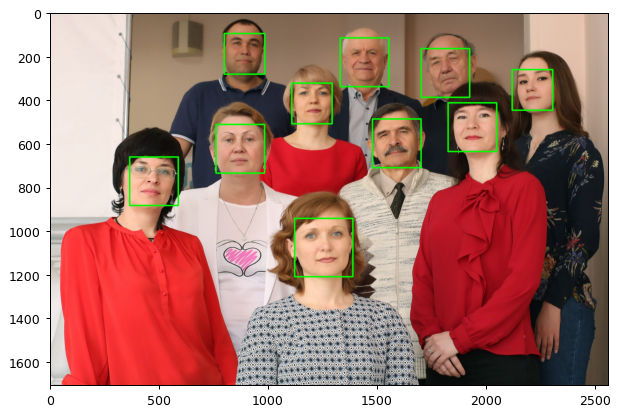

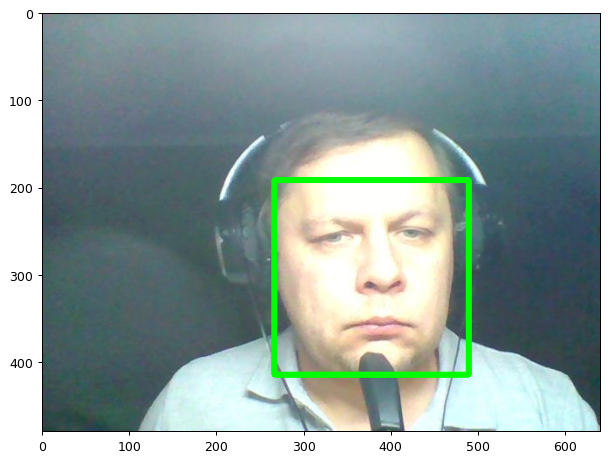

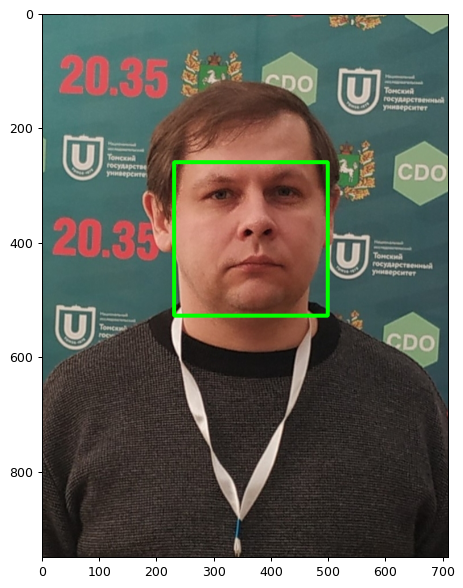

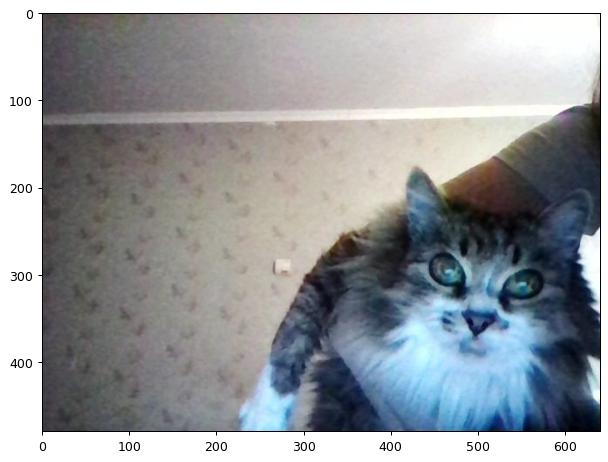

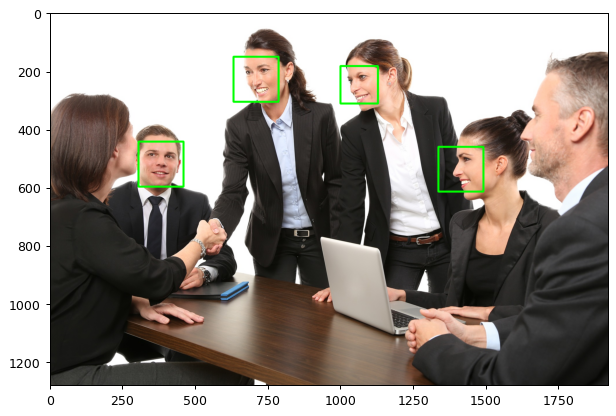

In [16]:
for photo in photos:
    face_det_fr(photo)

### Детекция лиц в MTCNN

Хорошие результаты детекции лиц и их ключевых особенностей дает также MTCNN - многозадачная каскадная сверточная нейронная сеть, описанная в работе "Совместное обнаружение и выравнивание лиц с использованием многозадачных каскадных сверточных сетей", Кайпэн Чжан и др. (см. пример [тут](https://www.machinelearningmastery.ru/face-detection-with-deep-learning-using-multi-tasked-cascased-cnn-8721435531d5/)).

In [17]:
!pip install mtcnn

     |████████████████████████████████| 2.3 MB 5.3 MB/s 


Импорт библиотеки

In [18]:
from mtcnn import MTCNN

Определим функцию детекции лиц на основе MTCNN

In [19]:
def face_det_mtcnn(photo_name):
    img = cv2.imread(photo_name)
    detector = MTCNN()

    face_list = detector.detect_faces(img) # face detect and alignment

    for face in face_list:
        box = face["box"]
        keypoints = face["keypoints"]

        # draw boundingbox
        x,y,w,h = box
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),5)

        # draw keypoints
        cv2.circle(img,keypoints["left_eye"],1,(0,0,255),5)
        cv2.circle(img,keypoints["right_eye"],1,(0,0,255),5)
        cv2.circle(img,keypoints["nose"],1,(0,0,255),5)
        cv2.circle(img,keypoints["mouth_left"],1,(0,0,255),5)
        cv2.circle(img,keypoints["mouth_right"],1,(0,0,255),5)
    
    # Посмотрим что получилось
    plt.figure(figsize=(8,8), dpi=90)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

Запустим детекцию лиц на фото

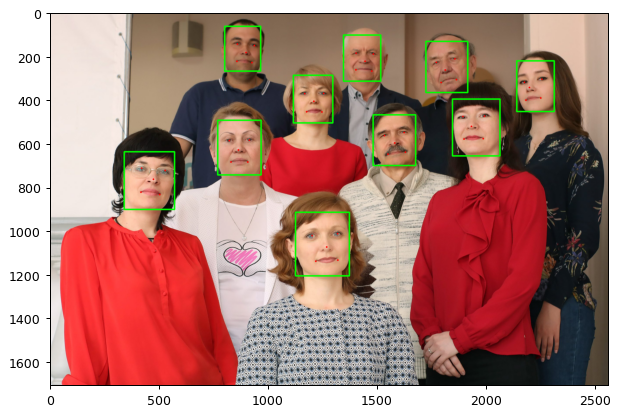

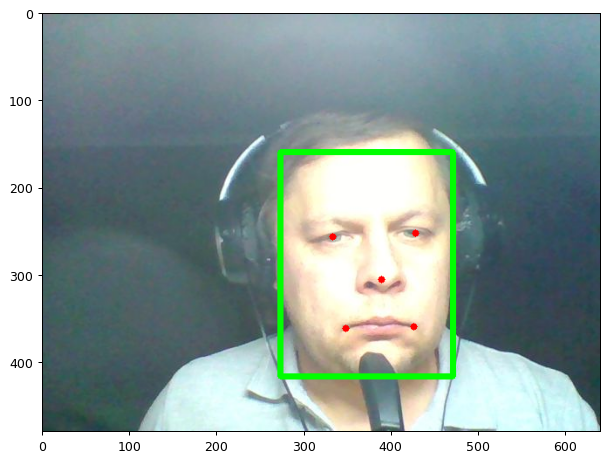

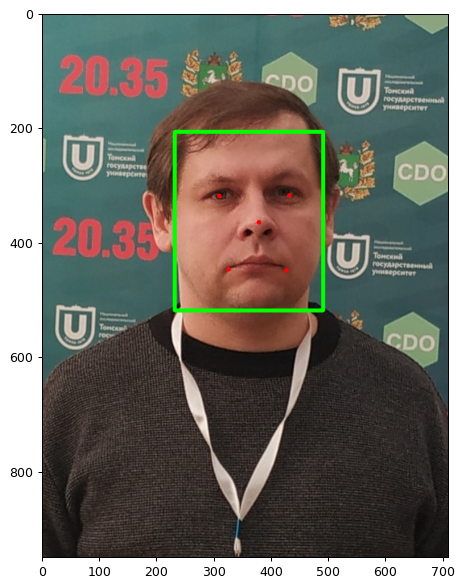

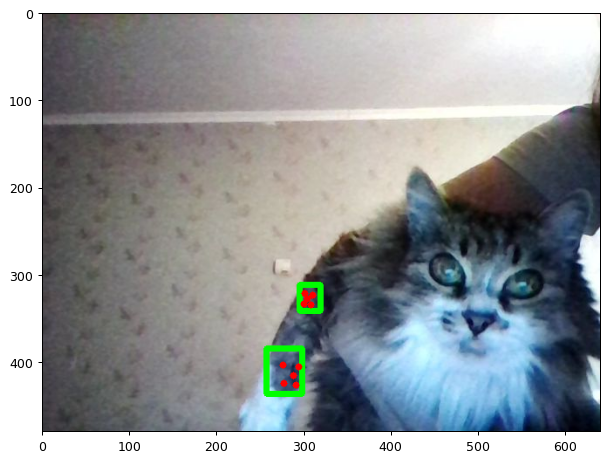

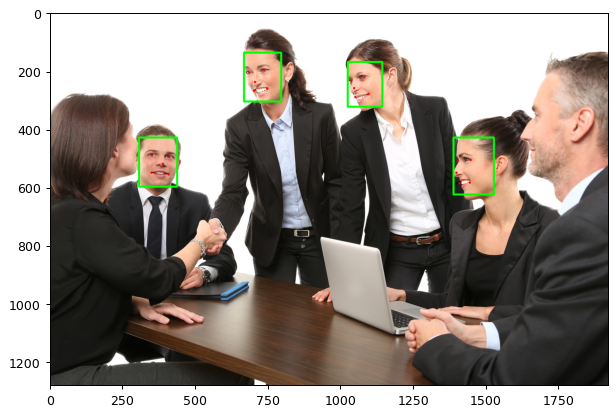

In [20]:
for photo in photos:
    face_det_mtcnn(photo)

##Применение Face recognition для детекции лиц в видео


Видео состоит из кадров, которые являются отдельными  картиками, поэтому работа с видео похожа на работу с изображениями.


Сначала отобразим загруженное видео:

In [33]:
from IPython.display import HTML
from base64 import b64encode
#mp4 = open('video1.mp4','rb').read()
mp4 = open('Kleo.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

In [34]:
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [35]:
#input_video = "video1.mp4" #Загруженное видео
input_video = "Kleo.mp4"

output_video = 'output.avi' #Выходное видео

output_video_res = (640, 360) #разрешение выходного видео

photo_pattern = "Photo.jpg" # фото-образец для распознования на видео

sign_photo = "Denis" #Подпись лица на видео

In [36]:
# открываем наше видео
input_movie = cv2.VideoCapture(input_video)
length = int(input_movie.get(cv2.CAP_PROP_FRAME_COUNT))

In [37]:
fourcc = cv2.VideoWriter_fourcc(*'XVID')
output_movie = cv2.VideoWriter(output_video, fourcc, 25, output_video_res)

image = face_recognition.load_image_file(photo_pattern)
face_encoding = face_recognition.face_encodings(image)[0]

known_faces = [
    face_encoding
]

face_locations = []
face_encodings = []
face_names = []
frame_number = 0

while True:
    # Берем отдельный кадр видео
    ret, frame = input_movie.read()
    frame_number += 1

    # Если кадры кончились, то завершаем цикл
    if not ret:
        break

    # Преобразовываем каждый кадр из BGR -> RGB (особенности работы opencv)
    rgb_frame = frame[:, :, ::-1]

    # Находим все лица на текущем кадре
    face_locations = face_recognition.face_locations(rgb_frame)
    face_encodings = face_recognition.face_encodings(rgb_frame, face_locations)

    face_names = []
    for face_encoding in face_encodings:
        
        # Проверяем, есть ли целевое лицо среди найденных
        match = face_recognition.compare_faces(known_faces, face_encoding, tolerance=0.50)

       
        name = None
        if match[0]:
            name = sign_photo # Если найдено целевое лицо, то присваиваем переменной нужную подпись

        face_names.append(name)

    # Подписываем результат
    for (top, right, bottom, left), name in zip(face_locations, face_names):
        if not name:
            continue
        
        cv2.rectangle(frame, (left, top), (right, bottom), (0, 255, 0), 2) # Обводим лицо рамкой зеленого цвета

        # Рисуем квадрат с подписью на кадре
        cv2.rectangle(frame, (left, bottom - 25), (right, bottom), (0, 255, 0), cv2.FILLED)
        font = cv2.FONT_HERSHEY_DUPLEX
        cv2.putText(frame, name, (left + 6, bottom - 6), font, 0.5, (255, 255, 255), 1)

    # Записываем текущий кадр в наше видео
    print("Writing frame {} / {}".format(frame_number, length))
    output_movie.write(frame)

Writing frame 1 / 154
Writing frame 2 / 154
Writing frame 3 / 154
Writing frame 4 / 154
Writing frame 5 / 154
Writing frame 6 / 154
Writing frame 7 / 154
Writing frame 8 / 154
Writing frame 9 / 154
Writing frame 10 / 154
Writing frame 11 / 154
Writing frame 12 / 154
Writing frame 13 / 154
Writing frame 14 / 154
Writing frame 15 / 154
Writing frame 16 / 154
Writing frame 17 / 154
Writing frame 18 / 154
Writing frame 19 / 154
Writing frame 20 / 154
Writing frame 21 / 154
Writing frame 22 / 154
Writing frame 23 / 154
Writing frame 24 / 154
Writing frame 25 / 154
Writing frame 26 / 154
Writing frame 27 / 154
Writing frame 28 / 154
Writing frame 29 / 154
Writing frame 30 / 154
Writing frame 31 / 154
Writing frame 32 / 154
Writing frame 33 / 154
Writing frame 34 / 154
Writing frame 35 / 154
Writing frame 36 / 154
Writing frame 37 / 154
Writing frame 38 / 154
Writing frame 39 / 154
Writing frame 40 / 154
Writing frame 41 / 154
Writing frame 42 / 154
Writing frame 43 / 154
Writing frame 44 / 1

Конвертируем полученное видео в удобный для отображения в Google Colab формат 

In [38]:
!ffmpeg -i output.avi output.mp4

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

In [39]:
mp4 = open('output.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

In [40]:
HTML("""
<video width=800 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [ ]:
# скачиваем получившееся видео.
files.download('output.avi')

А вообще, для обнаружения объектов на изображениях и видео, можно порекомендовать семейство нейронных сетей **YOLO**, вот несколько статей по этому инструменту:


1. YOLOv5 is Here: State-of-the-Art Object Detection at 140 FPS - https://blog.roboflow.com/yolov5-is-here/
2. YOLOv5: state-of-the-art модель для распознавания объектов - https://neurohive.io/ru/papers/yolov5-state-of-the-art-model-dlya-raspoznavaniya-obektov/
3. Scaled YOLO v4 самая лучшая нейронная сеть для обнаружения объектов на датасете MS COCO - https://habr.com/ru/post/531786/
4. YOLOv4 – самая точная real-time нейронная сеть на датасете Microsoft COCO - https://habr.com/ru/post/503200/
5. Обнаружение объектов с помощью YOLOv3 на Tensorflow 2.0 - https://habr.com/ru/post/556404/
6. Вот эта статья "Самая сложная задача в Computer Vision" описывает разный иструментарий, посвященный трекингу объектов, в том числе затрагивается и **Yolo v4** - https://habr.com/ru/company/recognitor/blog/505694/
7. Еще одна статья про трекинг "Как работает Object Tracking на YOLO и DeepSort" - https://habr.com/ru/post/514450/